In [1]:
!pip install -Uqq scikit-image

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure

In [2]:
# Prints the full path of each directory

for dirpath, dirnames, _ in os.walk('/kaggle/input'):
    for dirname in dirnames:
        print(os.path.join(dirpath, dirname))

/kaggle/input/chest-xray-pneumonia
/kaggle/input/chest-xray-pneumonia/chest_xray
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX
/kaggle/input/chest-xray-pneumonia/chest_xray/val
/kaggle/input/chest-xray-pneumonia/chest_xray/test
/kaggle/input/chest-xray-pneumonia/chest_xray/train
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL
/kaggle/input/chest-xray-pneumonia/chest_xray

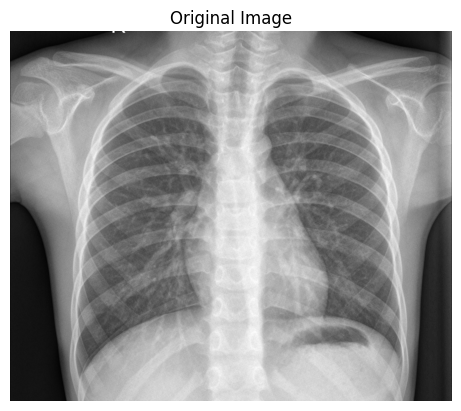

In [3]:
# Reads an image and converts it to grayscale

img = cv2.imread('/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0031-0001.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

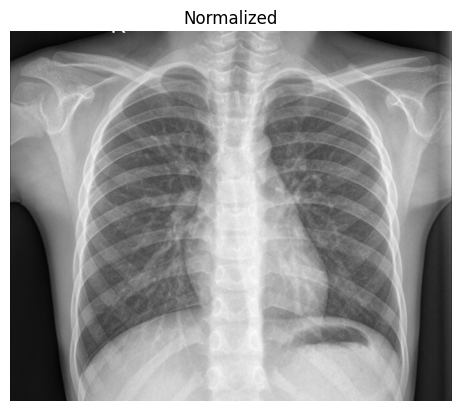

In [4]:
# Normalizes the image

mean = np.mean(img)
std = np.std(img)
img = img-mean
img = img/std

plt.imshow(img, cmap='gray')
plt.title('Normalized')
plt.axis('off')
plt.show()

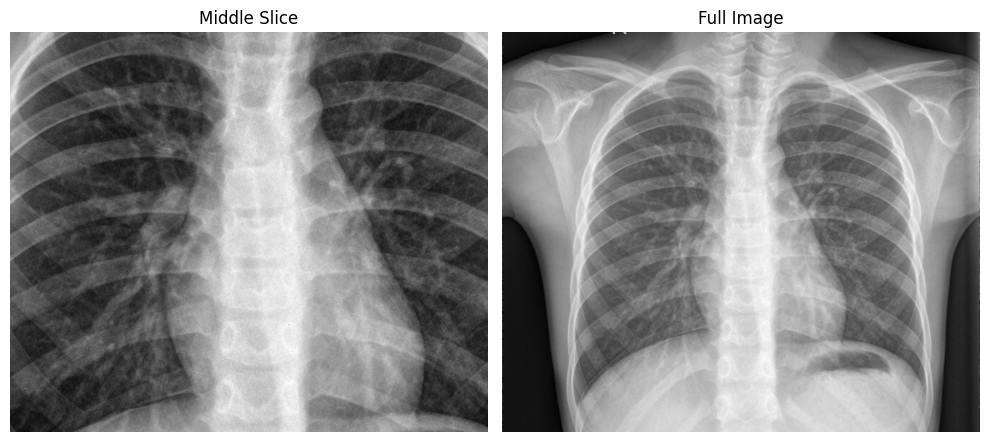

In [5]:
# Reduces noise/outliers by replacing min/max pixel values with the mean value of a central portion of the image

row_size = img.shape[0]
col_size = img.shape[1]
# Extract the number of rows and columns in the image

middle_row_start = int(row_size / 5)
middle_row_end = int(row_size * 4 / 5)
middle_col_start = int(col_size / 5)
middle_col_end = int(col_size * 4 / 5)

middle = img[middle_row_start:middle_row_end, middle_col_start:middle_col_end]
# Extract a middle portion of the image

mean = np.mean(middle)
# Calculate the mean of the pixel values in the middle portion
max = np.max(img)
min = np.min(img)
# Find the maximum and minimum pixel values in the entire image

img[img==max]=mean
img[img==min]=mean
# Replace maximum and minimum pixel values in the entire image with the calculated mean

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(middle, cmap='gray')
axs[0].set_title('Middle Slice')
axs[0].axis('off')

axs[1].imshow(img, cmap='gray')
axs[1].set_title('Full Image')
axs[1].axis('off')

plt.tight_layout()
plt.show()

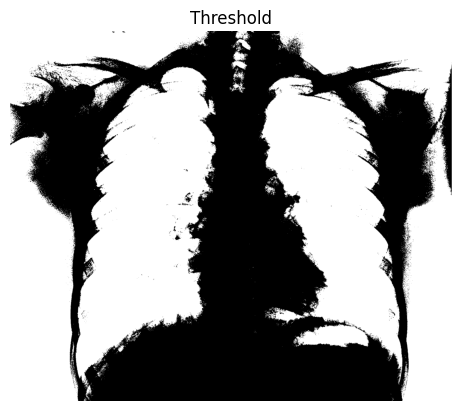

In [6]:
# Performs KMeans clustering and creates a binary thresholded image

kmeans = KMeans(n_clusters=2, n_init=10).fit(np.reshape(middle,[np.prod(middle.shape),1]))
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)
# Calculate the threshold value as the mean of the two cluster centers

thresh_img = np.where(img<threshold,1.0,0.0)
# Create a thresholded image by assigning pixel values based on whether they are below/above the threshold

plt.imshow(thresh_img, cmap='gray')
plt.title('Threshold')
plt.axis('off')
plt.show()

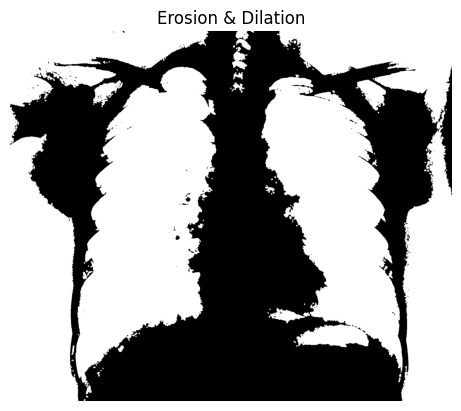

In [7]:
# Performs erosion and dilation on the thresholded image

eroded = morphology.erosion(thresh_img,np.ones([3,3]))
dilation = morphology.dilation(eroded,np.ones([5,5]))

plt.imshow(dilation, cmap='gray')
plt.title('Erosion & Dilation')
plt.axis('off')
plt.show()

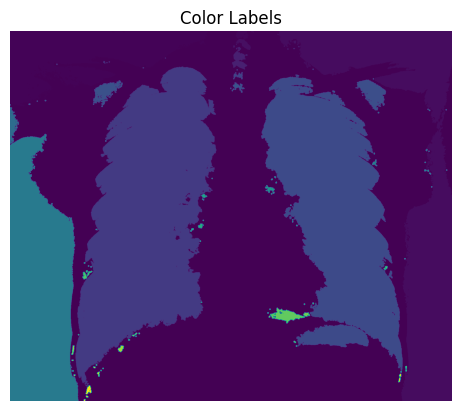

In [8]:
# Applies connected component analysis, assigning unique labels to connected regions

labels = measure.label(dilation)

plt.imshow(labels)
plt.title('Color Labels')
plt.axis('off')
plt.show()

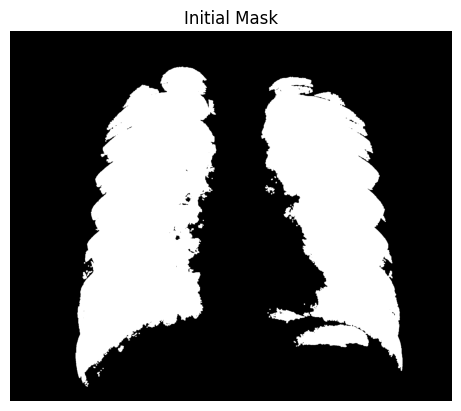

In [9]:
# Initial lung mask

regions = measure.regionprops(labels)
lungs = []

for region in regions:
    B = region.bbox
    if (B[0] < middle_col_end) and (B[1] < middle_row_end) and (B[2] > middle_col_start) and (B[3] > middle_row_start):
        if B[0] != 0 and B[1] != 0 and B[2] != col_size:
            lungs.append(region.label)
# Identify regions that intersect with the middle slice and do not touch the image borders, except the bottom border

mask = np.zeros_like(labels)
for i in lungs:
    mask = np.where(labels == i, 1, mask)
# Create a mask where regions identified as lungs are marked as 1 in the mask array
    
plt.imshow(mask, cmap='gray')
plt.title('Initial Mask')
plt.axis('off')
plt.show()

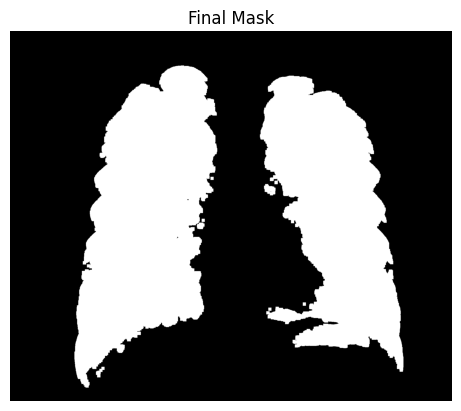

In [10]:
# Performs dilation on the mask

for i in lungs:
    mask = mask + np.where(labels==i,1,0)
mask = morphology.dilation(mask,np.ones([10,10]))

plt.imshow(mask, cmap='gray')
plt.title('Final Mask')
plt.axis('off')
plt.show()

(-0.5, 1948.5, 1631.5, -0.5)

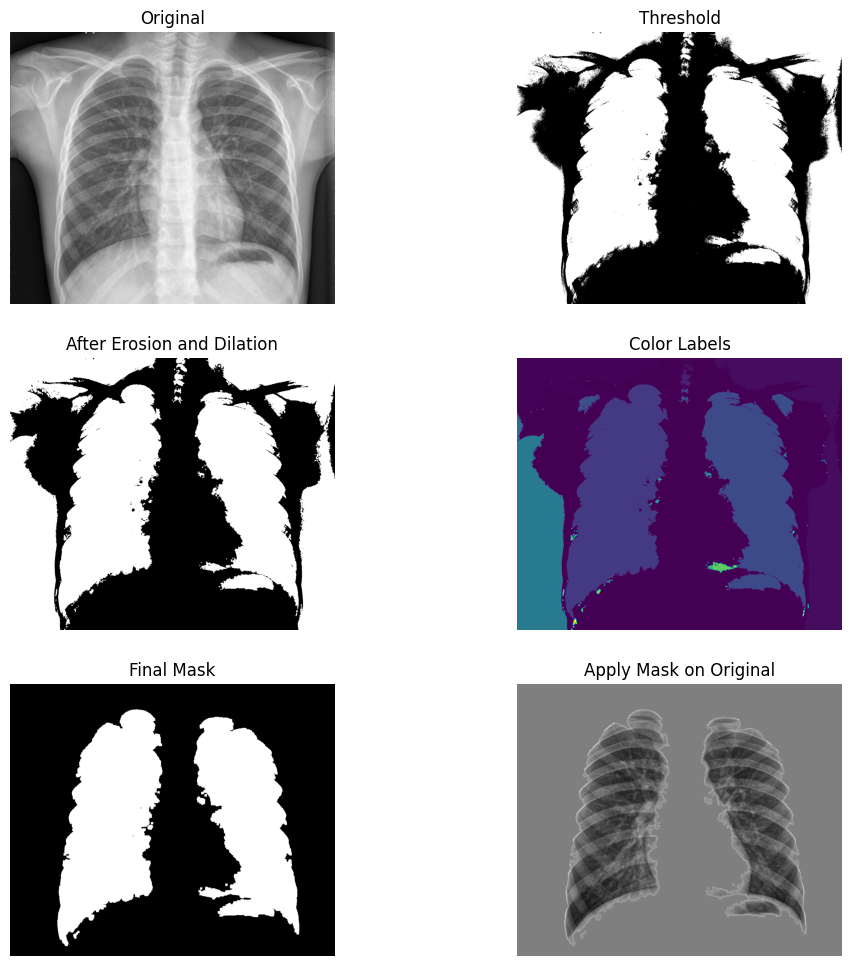

In [11]:
# Apply the mask to the original image and display each processing step

img_mask = mask*img

fig, ax = plt.subplots(3, 2, figsize=[12, 12])
ax[0, 0].set_title("Original")
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].axis('off')
ax[0, 1].set_title("Threshold")
ax[0, 1].imshow(thresh_img, cmap='gray')
ax[0, 1].axis('off')
ax[1, 0].set_title("After Erosion and Dilation")
ax[1, 0].imshow(dilation, cmap='gray')
ax[1, 0].axis('off')
ax[1, 1].set_title("Color Labels")
ax[1, 1].imshow(labels)
ax[1, 1].axis('off')
ax[2, 0].set_title("Final Mask")
ax[2, 0].imshow(mask, cmap='gray')
ax[2, 0].axis('off')
ax[2, 1].set_title("Apply Mask on Original")
ax[2, 1].imshow(img_mask, cmap='gray')
ax[2, 1].axis('off')